In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator

# Hyperparameters

In [18]:
hyperparam = {
    "data" : {
        "stake_training_data" : 0.75, 
        "path" : '../../../data/vega_shrinkwrapper_original/NewBlade/'
    },
    "model" : {
        "input_size" : 7,
        "n_hidden" : 150,
        "sequence_size" : 50,
        "batch_size" : 8,
        "lstm_layer" : 3,
        "gaussian" : 1
    },
    "cycling_lr" : {
        # step_size is the number of training iterations (total samples/batch_size) per half cycle. 
        # Authors suggest setting step_size 2-8 x training iterations in epoch.
        "step_size" : (2048/8)*2, 
        # Mode can be one of {triangular, triangular2, exp_range}
        "mode" : "triangular", 
        "gamma" : 0.9995,
        "base_lr" : 0.016, 
        "max_lr" :0.1
    },
    "training": {
        "n_epochs" : 2,
        "patience" : 50,
    }
}

# Split train and test data

In [19]:
class DataPreperator():
    def __init__(self, path):
        self.path = path
        
    def load_data(self):
        return pd.read_csv(self.path)
    
    def preprocess_data(self, train_data, validation_data):
        # Remove time feature
        train_data = train_data.drop(labels="Timestamp", axis=1)
        validation_data = validation_data.drop(labels="Timestamp", axis=1)
        # Initialise standard scaler
        scaler = StandardScaler()
        scaler.fit(train_data)
        # Transform data
        train_scaled = scaler.transform(train_data)
        validation_scaled = scaler.transform(validation_data)
        return train_scaled, validation_scaled
        
    def provide_data(self, stake_training_data):
        dataset = self.load_data()
        amount_training_data = round(len(dataset)*stake_training_data)
        train_data = dataset.iloc[0:amount_training_data,:]
        validation_data = dataset.iloc[amount_training_data:,:]
        train_preprocessed, validation_preporcessed = self.preprocess_data(train_data, validation_data)
        
        return train_preprocessed, validation_preporcessed

In [20]:
train_loader = DataPreperator(path=hyperparam['data']['path']+'NewBlade001.csv')
train_data, validation_data = train_loader.provide_data(stake_training_data=hyperparam['data']['stake_training_data'])


# Datahandler 
Time series data must be transformed into a structure of samples with `input` and `target` components before it can be used to fit a supervised learning model. <br>
For a time series interested in one-step predictions, the observations at prior time steps, so-called lag observations, are used as `input` and the `target` is the observation at the current time step.

For example, a univariate series can be expressed as a supervised learning problem with three time steps for `input` and one step as `target`, as follows:

|input|target|
|-----|------|
[1, 2, 3]|[4]
[2, 3, 4]|[5]
[3, 4, 5]|[6]

The Keras deep learning library provides the `TimeseriesGenerator` to automatically transform both univariate and multivariate time series data into such a format. 

## Size of multivariate time series
Actually the data has a other size than in the table above because of multivariate time series data and because of using batches. <br>
__First dimension__: batch size --> Defines the number of samples that will be propagated through the network simultaneously. <br>
__Second dimension:__ timesteps --> Number of sequence which is passed into the LSTM <br>
__Third dimension:__ input_dim --> Is the number of features. In this case data from 7 sensors, collected at the same time. <br>

![](../../knowledge/pictures/input_shape.png)

In [80]:
class DataSet(Dataset):
    def __init__(self, data, timesteps):
        # Data as numpy array is provided
        self.data = data
        # Data generator is initialized, batch_size=1 is indipendent of neural network's batch_size 
        self.generator = TimeseriesGenerator(self.data, self.data, length=timesteps, batch_size=1)

    def __getitem__(self, index):
        x, y = self.generator[index]
        x_torch = torch.from_numpy(x)
        # Dimension 0 with size 1 (created by TimeseriesGenerator because of batch_size=1) gets removed 
        # because DataLoader will add a dimension 0 with size=batch_size as well
        x_torch = torch.squeeze(x_torch) # torch.Size([1, timesteps, 7]) --> torch.Size([timesteps, 7])
        y_torch = torch.from_numpy(y)
        y_torch = torch.squeeze(y_torch)
        return (x_torch.float(), y_torch.float()) 

    def __len__(self):
        return len(self.generator)

In [81]:
dataset_train = DataSet(train_data, timesteps=hyperparam["model"]["sequence_size"])
dataset_validation = DataSet(validation_data, timesteps=hyperparam["model"]["sequence_size"])

# Data is shuffled because each mini batch is indipendent from each other, but samples of a minibatch are in chronological order
data_loader_training = DataLoader(dataset_train, batch_size=hyperparam["model"]["batch_size"], 
                                  num_workers=1, shuffle=True, drop_last=True)
data_loader_validation = DataLoader(dataset_validation, batch_size=hyperparam["model"]["batch_size"], 
                                    num_workers=1, shuffle=True, drop_last=True)

In [82]:
for batch_idx, data in enumerate(data_loader_training):
    x,y = data
    print('Data of batch: {}'.format(batch_idx))
    print("Size of input data: {}".format(x.size()))
    print("Size of target data: {}".format(y.size()))
    if batch_idx >=1: break

Data of batch: 0
Size of input data: torch.Size([8, 50, 7])
Size of target data: torch.Size([8, 7])
Data of batch: 1
Size of input data: torch.Size([8, 50, 7])
Size of target data: torch.Size([8, 7])


## Define Architecture of Neural Network
__Parameters for LSTM Modul:__
- input_size : The number of expected features in the input x
- hidden_size :The number of features in the hidden state h
- num_layers : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results.
- batch_first : If True, then the input __and output__ tensors are provided as (batch, seq, feature).
- dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0

## Model which contains 2 parallel full conected layer (y_hat and sigma seperatly)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, batch_size, input_dim, n_hidden, n_layers):
        super(LSTM, self).__init__()
        # Attributes for LSTM Network
        self.input_dim = input_dim
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        # Definition of NN layer
        # batch_first = True because dataloader creates batches and batch_size is 0. dimension
        self.lstm = nn.LSTM(input_size = self.input_dim, hidden_size = self.n_hidden, num_layers = self.n_layers, batch_first = True)
        self.fc_y_hat = nn.Linear(self.n_hidden, self.input_dim)
        self.fc_tau = nn.Linear(self.n_hidden, self.input_dim)
        
    def forward(self, input_data, hidden):
        # Forward propagate LSTM
        # LSTM in Pytorch return two results the first one usually called output and the second one (hidden_state, cell_state). 
        # As output the LSTM returns all the hidden_states for all the timesteps (seq), in other words all of the hidden states throughout
        # the sequence
        # As hidden_state the LSTM returns just the most recent hidden state
        lstm_out, (hidden_state, cell_state) = self.lstm(input_data, hidden)
        # Length of input data can varry 
        length_seq = input_data.size()[1]
        # Select the output from the last sequence 
        last_out = lstm_out[:,length_seq-1,:]
        out_y_hat = self.fc_y_hat(last_out)
        out_tau = self.fc_tau(last_out)
        #σ = exp(τ) guarantees σ > 0 and provides numerical stability in the learning process
        sigma = torch.exp(out_tau)
        return out_y_hat, sigma
    
    def init_hidden(self):
        # This method is for initializing hidden state as well as cell state
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        h0 = torch.zeros(self.n_layers, self.batch_size, self.n_hidden, requires_grad=False)
        c0 = torch.zeros(self.n_layers, self.batch_size, self.n_hidden, requires_grad=False)
        return [t for t in (h0, c0)]

### Loss function Prof. Niggemann
--> Energie wird betrachtet

In [84]:
class LossModule(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate the module and assign them as
        member variables.
        """
        super(LossModule, self).__init__()

    def forward(self, output, target_data):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. 
        """
        # Compute loss
        mean_loss = torch.sum((output - target_data)**2, dim=1) / hyperparam["model"]["input_size"]
        mean_loss = torch.sum(mean_loss) / hyperparam["model"]["batch_size"]
        return mean_loss

In [85]:
def loss_function(output, target_data):
    y_hat, sigma = output
    # target_data.size(batch_size,1,7) because timestep = 1
    # new target_data.size(batch_size,7)
    target_data = torch.squeeze(target_data)
    
    term = ((target_data-y_hat)/sigma).pow(2) + 2*torch.log(sigma)
    loss_batches = torch.sum(input=term, dim=1)
    
    # The value being returned by a loss function MUST BE a scalar value. Not a vector/tensor.
    mean_loss = torch.sum(loss_batches)/hyperparam['model']['batch_size']
    
    # The value being returned must be a Variable. This is so that it can be used to update the parameters. 
    # A Variable is tracking the operations being done on it so that it can backpropagate to get the gradient.
    return Variable(mean_loss, requires_grad=True)

## Training Loop
An epoch consists of a learning cycle over all batches of training data and an evaluation of the most recent model with the testing data. 

In [87]:
# Initialize model
torch.manual_seed(0)
model = LSTM(batch_size=hyperparam['model']['batch_size'], input_dim=hyperparam['model']['input_size'], 
             n_hidden=hyperparam['model']['n_hidden'], n_layers=hyperparam['model']['lstm_layer'])


# Initialize optimizer and Cyclic Learning Rate
# lr=1. because of scheduler (1*learning_rate_schedular)
optimizer = torch.optim.SGD(model.parameters(), lr=1.)  

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, base_lr=hyperparam['cycling_lr']['base_lr'], 
                                              max_lr=hyperparam['cycling_lr']['max_lr'], step_size_up=hyperparam['cycling_lr']['step_size'], 
                                              mode=hyperparam['cycling_lr']['mode'], gamma=hyperparam['cycling_lr']['gamma'])

print("Start model training")
# Create lists to save training loss and validation loss of each epoch
hist_loss = []
lr_find_lr = []

# Set first comparative value
lowest_loss = 99
trails = 0

for epoch in range(hyperparam['training']['n_epochs']):
    # Empty list for recording performance 
    epoch_training_loss = []
    epoch_validation_loss = []
    
    model.train()
    
    ##### Training #####
    for batch_number, data in enumerate(data_loader_training):
        # The LSTM has to be reinitialised, otherwise the LSTM will treat a new batch as a continuation of a sequence.
        # When batches of data are independent sequences, then you should reinitialise the hidden state before each batch. 
        # But if your data is made up of really long sequences and you cut it up into batches making sure that each batch 
        # follows on from the previous batch, then in that case you wouldn’t reinitialise the hidden state before each batch.
        # In the current workflow of class DataProvoider independent sequences are returned. 
        
        input_data, target_data = data
        
        hidden = model.init_hidden()
        
        # Zero out gradient, else they will accumulate between minibatches
        optimizer.zero_grad()
        
        # Forward propagation
        output = model(input_data, hidden)
         
        # Calculate loss
        criterion = LossModule()
        loss = criterion(output, target_data)
        epoch_training_loss.append(loss.item())
    
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Update LR
        scheduler.step()
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)
        
    # Save mean of loss over all training iterations
    mean_epoch_training_loss = sum(epoch_training_loss) / float(len(epoch_training_loss))
    
    ##### Evaluation #####
    for batch_number, data in enumerate(data_loader_validation):
        input_data, target_data = data
        model.eval()
        hidden = model.init_hidden()
        
        output = model(input_data, hidden)
        
        # Calculate loss
        criterion = LossModule()
        loss = criterion(output, target_data)
        epoch_validation_loss.append(loss.item())
    
    # Save mean of loss over all validation iterations
    mean_epoch_validation_loss = sum(epoch_validation_loss) / float(len(epoch_validation_loss))
    
    # Save training and validation loss to history
    hist_loss.append({'epoch': epoch, 
                      'training': mean_epoch_training_loss, 
                      'validation': mean_epoch_validation_loss})
    
    print("-------- epoch_no. {} finished with eval loss {}--------".format(epoch, mean_epoch_validation_loss))
        
    # Check after every evaluation whether the latest model is the best one or not
    # If this is the case, set current score to best_score, reset trails and save the model.
    if mean_epoch_validation_loss < lowest_loss:
        trials = 0
        lowest_loss = mean_epoch_validation_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mean_epoch_validation_loss
        }, "../../../models/ML_model/best_model.pt")
        print("Epoch {}: best model saved with loss: {}".format(epoch, mean_epoch_validation_loss))
    
    # Else: Increase trails by one and start new epoch as long as not too many epochs 
    # were unsuccessful (controlled by patience)
    else:
        trials += 1
        if trials >= hyperparam['training']['patience'] :
            print(f'Early stopping on epoch {epoch}')
            break  

# Safe results to csv file
df = pd.DataFrame(hist_loss)
print(df)
df.to_csv("../../../models/statistics/history_ML.csv", sep=";", index=False)

Start model training
-------- epoch_no. 0 finished with eval loss 1.0470433507049293--------
Epoch 0: best model saved with loss: 1.0470433507049293
-------- epoch_no. 1 finished with eval loss 0.7301198317293536--------
Epoch 1: best model saved with loss: 0.7301198317293536
   epoch  training  validation
0      0  0.650653    1.047043
1      1  0.272859    0.730120


In [68]:
import numpy as np
import pandas as pd
x = range(len(lr_find_lr))
data = pd.DataFrame(data={'y': lr_find_lr, 'x': x})
data.head()

,y,x
0,0.016164,0
1,0.016328,1
2,0.016492,2
3,0.016656,3
4,0.016820,4


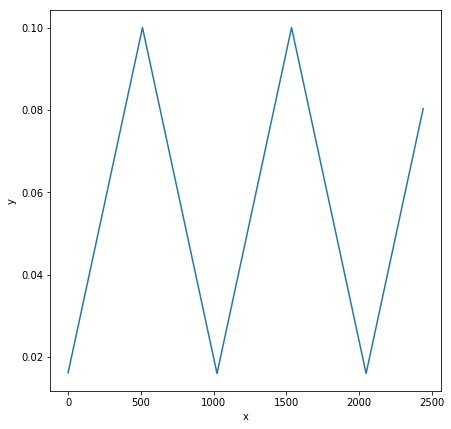

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt


f, ax = plt.subplots(figsize=(7, 7))
#ax.set(xscale="log")
sns.lineplot(x=data.x, y=data.y, ax=ax)
plt.show()

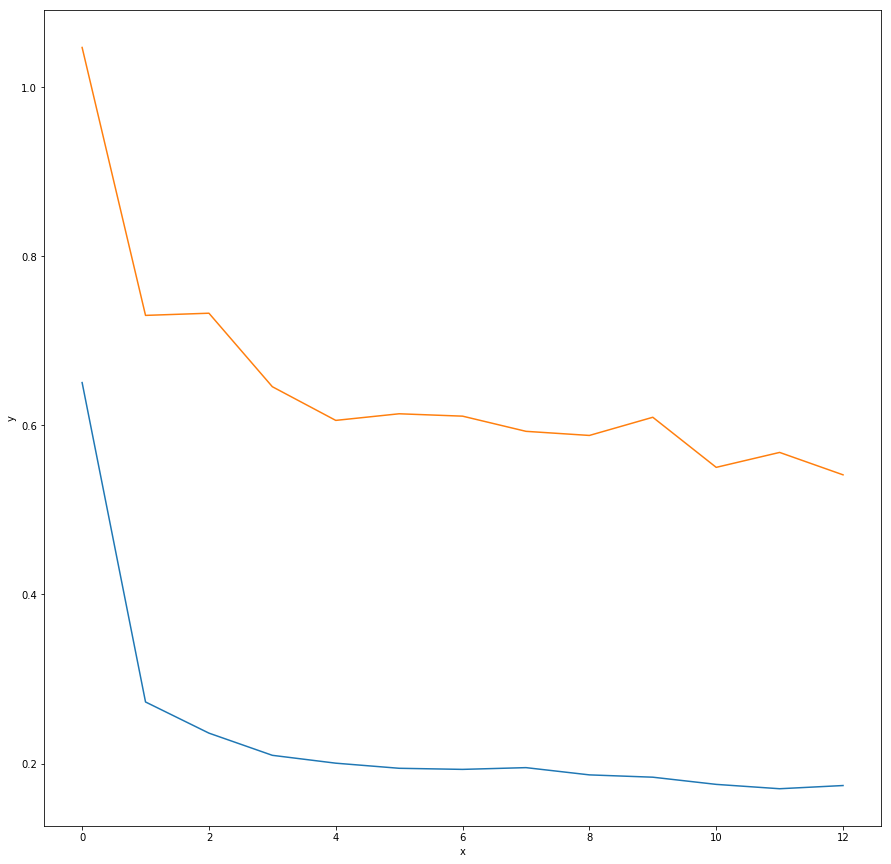

In [74]:
epoch_no_training = range(len(hist_training_loss))
epoch_no_validation = range(len(hist_validation_loss))
loss_training = pd.DataFrame(data={'y': hist_training_loss, 'x': epoch_no_training})
loss_validation = pd.DataFrame(data={'y': hist_validation_loss, 'x': epoch_no_validation})
f, ax = plt.subplots(figsize=(15, 15))
sns.lineplot(x=loss_training.x, y=loss_training.y, ax=ax)
sns.lineplot(x=loss_validation.x, y=loss_validation.y, ax=ax)
plt.show()